In [1]:
import sys 
sys.version_info > (3, 5)

import numpy as np
import tensorflow as tf
assert tf.__version__ > "2.0"
from tensorflow import keras
import matplotlib.pyplot as plt

# Overview

## Autoencoders

Autoencoders are artificial neural networks that are able to learn without supervision (i.e. unlabelled data), called **Latent Representations** or, **Codings**. The architecture reminds me of a diverging converging nozzle. Autoencoders learn to copy inputs to their outputs but with noise and constraints being added between. This forces the network to learn efficient ways of representing the data.

You can think of autoencoders as self-supervised learning, where it automatically generates labels - in the autoencoders case the labels are simply the input.  

![Image](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQgW2FLPNORORZ7GoIPLJIQU0WB4BIDT4S0bA&usqp=CAU)

The codings are useful as it can reduce dimensionality of the input data, therefore, acting as a feature detector. They also can be used for unsupervised pretraining of a deep neural network. Some Autoencoders are **Generative Models** and can randomly generate new data, although this is not as convicing as the data generated by **Generative Adversarial Networks (GANs)**. 

Given two sequences: 

1. 1 , 3, 6, 9, 12 

2. 34, 54, 21, 643, 765, 31

It would difficult to memorise each of them. However, if you look more closely at the first sequence we can see a pattern. This same approach is taken for Autoencoders, it attempts to discover and exploit patterns within the data. 

Autoencoders are split into two parts:

- Encoder, the recognition network, which converts inputs into **Latent Representation**, and,

- Decoder, the generative network, which converts the latent representation into outputs called *reconstructions*. 

Within the network the inputs reduce in dimensionality but yet find a way to reduce the reconstruction loss. The autoencoder is said to be **Undercomplete**. Forcing it to learn meaningful patterns within the data and drop the unimportant ones. - see Performing PCA section below.

## Generative Adversarial Networks (GANs)

There are two neural networks:

- **Generator**: that attempts to generate data that looks similiar to training data.
- **Discriminator**: that attempts to tell real data from fake data.

The two networks compete against each other. **Adversarial Training** is one of the most important recent ideas.  

#### Examples of GANs generating data
- [This](https://www.thispersondoesnotexist.com/) website shows faces generated by the StyleGAN architecture and is very hard to believe that these people do not exist.

- [This](https://thisrentaldoesnotexist.com/) website shows Airbnb bedrooms  that do not exist.

- Increase the resolution of an image.

- Colorization, [here](https://github.com/jantic/DeOldify) is a link to a really good project that can colorize your old pictures using a GAN machine learning model.

There are many more, such as predicting the next frame in a video, augmenting data, and identifying weaknesses in a model and improve it.

---


# Types of Autoencoders


## Undercomplete Autoencoders

### Performing PCA with Undercomplete Linear Autoencoder 

The example below performs PCA on a 3D dataset, the encoder compresses the data while the decoder returns it back to the original input shape.

In [2]:
# to perform PCA we do not need to specify activation functions and cost function must equal mse
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder]) # combine encoder and decoder

autoencoder.compile(loss='mse', optimizer='sgd') 

### Stacked Autoencoders

Autoencoders which have several hidden layers are called **Stacked Autoencoders**, or **Deep Autoencoders**. As with other deep neural networks, they can learn complex patterns however, we need to make sure that we do not overfit the network; whereby the encoder maps an input to an arbitrary number and the decoder learn reverse mapping from that number. 



In [3]:
# encoder half
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])

# decoder half
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# combine encoder and decoder to make a stacked autoencoder 
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])


def rounded_accuracy (y_true, y_pred):
  """
  Metric to use when comparing on and off pixels.
  """
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5),
                   metrics=[rounded_accuracy])

Everything should make sense apart from the `binary_crossentropy` loss and `rounded_accuracy` function. 

This enables the reconstruction task to be a multilabel binary classification problem. Rather than predicting the a pixels intensity (i.e. from 0 to 255) regression task, we are now predicting whether it is black or white (i.e. 0 or 1). This allows the model to converge faster. 

#### Visualization

One huge benefit of Autoencoders is that they can handle large datasets. One caveat is that they do not output great visualizations so another dimensionality reduction algorithm, such as TSNE, MDS or manifold learning, can be used to visualise the data. 

```
# example of using the encoder part of the autoencoder to reduce dimensionality 
X_valid_compressed  = stacked_encoder_model.predict(X_valid)

# then use TSNE to reduce dimensionality futher to 2 for plotting
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

# --- code for plot ---
```
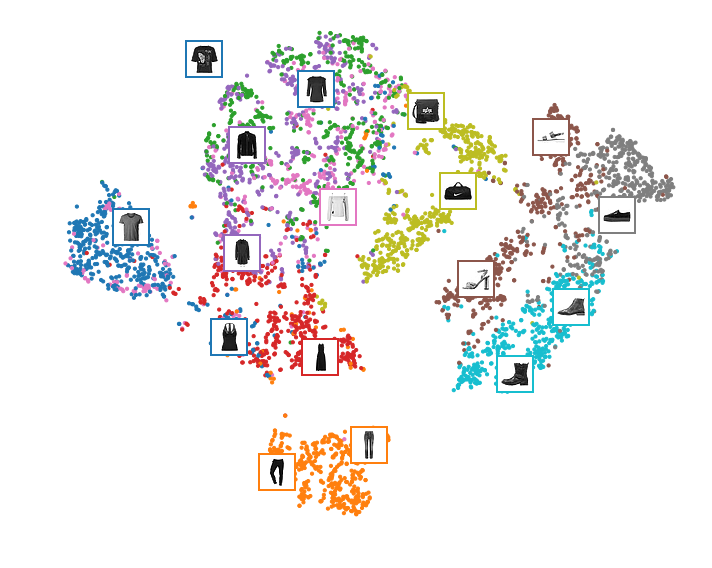


#### Unsupervised Pretraining

When you have a dataset with many instances that are unlabelled, you can train a stacked autoencoder using all the data. Then resuse (i.e. copy the weights) the encoder section and train it for the actual task with the labelled data. 

<br/>

##### Tying Weights

The autoencoders, typically, have a symmetrical architecture. This brought light the idea of **tying the weights** so that the decoder layers share the weights with the encoder layers weights. 

In [4]:
class DenseTranspose(keras.layers.Layer):
  """
  Class that can be used a decoder layer, which copies the weights from the dense
  argument.
  """
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)
  
  def build(self, batch_input_shape):
    self.biases = self.add_weight(name='bias',
                                  shape=[self.dense.input_shape[-1]],
                                  initializer='zeros')
    super().build(batch_input_shape)
  
  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)


We can then create autoencoder that has half the number of weights, hence, half the number of parameters and speeding up convergence.

In [5]:
dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  dense_1, 
  dense_2
])

tied_decoder = keras.models.Sequential([
  DenseTranspose(dense_2, activation='selu'),
  DenseTranspose(dense_1, activation='sigmoid'),
  keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(learning_rate=1.5),
                metrics=[rounded_accuracy])

![Stacked Autoencoder](https://miro.medium.com/max/1128/1*7H9VQlN94-wv7Ianqt6GZg.png)

There are other ways to train a stacked model, such as greedy layerwise training, where we train one autoencoder at a time within the network. Splitting the network into smaller pieces. 


### Convolution Autoencoders

So far, we have only used Dense networks but we can also build convolutional and recurrent autoencoders. Convolutional networks are far superior for computer vision tasks and convolutional autoencoders are no different. 

Convolutional autoencoders are great for unsupervised pretraining or dimensionality reduction for images. 

Within the network, the encoder decreases in size (height and width) while increasing in depth (feature maps) while the decoder does the opposite - so you can use a Transpose the convolutional layers, also known as a Deconvolution.

In [6]:
conv_encoder = keras.models.Sequential([
  keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
  keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='selu'),
  keras.layers.MaxPool2D(pool_size=2),
  keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='selu'),
  keras.layers.MaxPool2D(pool_size=2),
  keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='selu'),
  keras.layers.MaxPool2D(pool_size=2),
])

# use Conv2DTranspose to make transformations go in the opposite direction to a normal convolutional layer
conv_decoder = keras.models.Sequential([
  keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='valid',
                               activation='selu', input_shape=[3, 3, 64]),
  keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same',
                               activation='selu'),
  keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',
                               activation='sigmoid'),
  keras.layers.Reshape([28, 28])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])

In [7]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

### Recurrent Autoencoders

Recurrent autoencoders can be used for sequences, such as time series and text. Similiar to convolutional autoencoders, we can use them for dimensionality reduction or for unsupervised pretraining/learning.

The encoder is a sequence to vector RNN while the decoder is vector to sequence RNN. 


In [8]:
recurrent_encoder = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
  keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
  keras.layers.RepeatVector(28, input_shape=[30]),  # repeats vector input
  keras.layers.LSTM(100, return_sequences=True),
  keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

So far we have seen autoencoders that have a symmetrical architecture with the network becoming narrower till it gets to smallest point, the coding layer. The models are called Undercomplete autoencoders. 

The next section focusses on overcomplete autoencoders, where the coding layer can be much larger.

## Overcomplete Autoencoders

### Denoising Autoencoders

This type of autoencoder adds noise, either in the form of Gaussian noise, `GaussianNoise` Layer, or `Dropout` (turning neurons off within the encoder's input layer), and is trained to recover the original noise free inputs. Note, the noise is turned on only during training. 


In [9]:
dropout_encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dropout(0.5), #  replace with GaussianNoise 
  keras.layers.Dense(100, activation='selu'),
  keras.layers.Dense(30, activation='selu')
])

dropout_decoder = keras.models.Sequential([
  keras.layers.Dense(100, activation='selu', input_shape=[30]),
  keras.layers.Dense(28 * 28, activation='sigmoid'),
  keras.layers.Reshape([28, 28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])

Not only do we see the usual benefits of autoencoders with the denoising autoencoder, such as visualization and unsupervised pretraining, we also can use it for removing noise from images. 

### Sparse Autoencoders

Another constraint that we can add to the coding layer is sparsity. Where we push to reduce the number of active neurons, to say 5%. Forcing the autoencoder to represent a feature in a small number of neuron combinations. 

<br/> 

**1. Sigmoid**

One approach is to simply set `activation='sigmoid'` within the coding layer to constrain the coding values between 0 and 1. With most values falling within the saturating points, i.e. 0 or 1.  




In [10]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])

simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])


**2. Activity Regularization with $\ell_1$ norm**

A second approach is to add an `ActivityRegularization` layer to the coding layer. This adds another term within the training loss funciton. Where the term's training loss is equal to the sum of absolute values of its inputs. This forces the codings to be close to 0, but it will also be penalised if it does not reconstruct the inputs correctly, thus a few nonzero values are required. 


In [11]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid",
                       activity_regularizer=keras.regularizers.l1(1e-3)),
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])


**3. Measure Sparsity in Coding layer using Kullback-Leibler (KL) divergence**

The aproach that achieves better results is using the KL divergence to limit the neurons that are too active and increase those that are not active enough. We use the KL divergence because it is has stronger gradients compared to $\ell_1$, MAE, and $\ell_2$, MSE.  

This approach adds a sparsity loss to the cost function. Adding another hyperparameter which controls the relative loss between the sparsity loss and reconstruction loss. 

The sparsity autoencoder can have an coding layer that is mostly close to 0 with a mean activation between of 0.1 and 0.2. 


In [12]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  """
  Class that can be passed to the activation_regularizer argument within a layer.
  """
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target
  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * (
        kl_divergence(self.target, mean_activities) +
        kl_divergence(1. - self.target, 1. - mean_activities))

In [13]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])

sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])

### Variational Autoencoders

Probably the most popular type of autoencoder because they are both probabilistic and generative autoencoders. They are similiar to Restricted Boltzmann Machines (RBMs). It uses probabilities and is able to generate new instances like they were sampled from the training set.

Variational autoencoders perform variational Bayesian inference. *Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available.*

As with all autoencoders there is an encoder followed by a decoder. However the biggest difference is the coding layer. The encoder produces a mean $\mu$ and standard deviation $\sigma$, these values are then used to produce new based on Gaussian distributions. For a single instance, the coding will look like they have been sampled from a simple Gaussian distribution and then decoded by the decoder.  

The **cost function**, during training, forces the codings to become a cloud of Gaussian points from the coding space (i.e latent space). In order to generate new samples we just simply take a random coding from the Gaussian distribution. 

The `cost function`  = `reconstruction loss` + `latent loss`.

The `latent loss` pushes the autoencoder to have codings that have come from a simple Gaussian distribution (it is the KL divergence between the target distribution and actual distribution of the codings). 

The formula for latent loss is not that complex and can be simplified to aid with the computation, for example, changing $\sigma$ to $\log (\sigma^2)$ within the latent loss formula helps speed up convergence.

<br/>


Variational encoders were great until GANs came along...

---

# Generative Adversarial Networks

GANs were introduced in 2014. The concept is simple, make neural networks compete against each other. It comprises of two neural networks:

- Generator: offers the same functionality as the decoder in variational autoencoders, whereby it takes in a latent representations (i.e. codings) and generates a new image as an output. 
- Discriminator: has to decide whether the input is fake or real. 

The generator and discriminator have opposite goals. The generator must try create fake images that look like real images but the discriminator must find these fakes images. 

GANs are used for image processign tasks such as super resolution, colorisation, image editting and turning a sketch into a photorealistic image, or predicting the next frames in a video. They even help identify weaknesses in other models and strengthens them. 


## Training Interation

The output of the generator is one of the inputs (alongside the original image) to the discriminator network. This makes training difficult due to the different objectives, we cannot train it as we do with regular neural networks. 
We must divide the training into the following phases:

1. Train the discriminator. Given a batch of real and fake images (plus their respective labels) using a binary cross-entropy loss. Using backpropagation we only optimise the weights for the discriminator. 

2. Train the generator. Freezing the discrimnator and passing it fake data with labels that represent that they are real. The gradients flow back from the discriminator to the generator. This forces the generator to produce images that the discriminator will (wrongly) beleive to be real. 


## Problems with Training GANs

Doing the above in practice is not easy as you can no longer can call the `.fit()` method because you need to unfreeze/freeze the discriminator as well as being able to produce fake data (i.e. noisy images). You must set `.trainable=False`, this attribute will help seperate out the training between the two networks.  After doing this you will find that GANs will forget what they have learnt and can be a challenge in training them. 

![GAN Architecture](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41524-020-00352-0/MediaObjects/41524_2020_352_Fig1_HTML.png)

In [14]:
# load MNIST fashion dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [15]:
codings_size = 10

generator = keras.models.Sequential([
  keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
  keras.layers.Dense(150, activation="selu"),
  keras.layers.Dense(28 * 28, activation="sigmoid"),
  keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(150, activation="selu"),
  keras.layers.Dense(100, activation="selu"),
  keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])

In [16]:
# note. do not need to compile generator because it is trained through the GAN model
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [17]:
# create dataset to iterate through
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [18]:
# custom GAN training function

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    for X_batch in dataset:
      # phase 1 - training the discriminator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
      y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_and_real, y1)
      # phase 2 - training the generator
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y2)

In [19]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [20]:
def plot_multiple_images(images, n_cols=None):
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1
  if images.shape[-1] == 1:
    images = np.squeeze(images, axis=-1)
  plt.figure(figsize=(n_cols, n_rows))
  for index, image in enumerate(images):
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

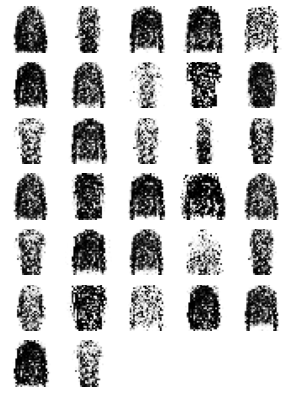

In [21]:
noise = tf.random.normal(shape=[batch_size, codings_size])

plot_multiple_images(generator(noise), n_cols=5)

As you can see, even after 50 epochs we still have a lot of noise within the image. Further clarifying that the GAN networks can be forgetful and this is because of the zero-sum game. 

## Game Theory - Nash Equilibrium

As training advances the generator and discriminator may end up in a state called a Nash Equilibrium. Where no player is better off changing their own strategy. 

Concretely, the GAN can reach nash equilibrium if the generator produces perfectly realistic data and the discriminator is forced to guess. 

As mentioned, the GAN network often forgets and is unstable across classes. The problem with the generator and discriminator is **mode collapse**. This is when the generator realises that it fools the discriminator because it produces a certain class, for example, a boot. The generator will then forget how to produce fake images of other classes. The discriminator realises this and then learns to pick up the fake boot images. Leading to the generator to move onto another class, a trouser for instance. 

This oscilation and unstable nature between classes is due to the generator and discriminator pushing against each other. During training of GANs you will observe a convergence and then sudden divergence as generator tries to find another class to replicate. Consequently, GANs are sensitive to hyperparameters selected so tuning them is crucial and requires a lot of effort. 

A lot of GAN architectures have sparked and it is an active area of research. Modifications in the architecture as well as the cost function. Check out this Github repo for more details: https://github.com/hwalsuklee/tensorflow-generative-model-collections 

![GAN Architecture on MNIST Digits](https://xiaohongliu.ca/post/gan/featured.png)

## Types of GANs

There are many types of GANs but an overview of popular GANs have been described below. 

### 1. Deep Convolutional GANs

One pattern that is observed when it comes to neural networks is that the deeper the network, generally, is the way to go for getting a better model. 

The Deep Convolutional GAN (DCGAN) was one of the first stable convolutional GANs. It was able to stablise the network by the following: 

1. Replace pooling layers with strided convolutions, in the discriminator, and transposed convolutions, in the generator. 
2. Batch Normalization expect in generator's output layer and discrimnator's input layer. 
3. Replace fully connected hidden layers with deep architecture. 
4. ReLU activation in generator expect the output layer (use tanh).
5. Leaky ReLU activation in discriminator. 

However, you still need to experiment with several hyperparameters as these guidelines might not always work. 

In [22]:
# example DCGAN

codings_size = 100

generator = keras.models.Sequential([
  keras.layers.Dense(7 * 7 *128, input_shape=[codings_size]),
  keras.layers.Reshape([7, 7, 128]),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME',
                               activation='selu'),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='SAME',
                               activation='tanh')
])

discriminator = keras.models.Sequential([
  keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME',
                               activation=keras.layers.LeakyReLU(0.2),
                               input_shape=[28, 28, 1]),
  keras.layers.Dropout(0.4),
  keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='SAME',
                               activation=keras.layers.LeakyReLU(0.2)),
  keras.layers.Dropout(0.4),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

dcgan = keras.models.Sequential([generator, discriminator])

# as before compile the discriminator 
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
dcgan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [23]:
dcgan.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_31 (Sequential)   (None, 1)                 1812225   
Total params: 2,652,930
Trainable params: 840,321
Non-trainable params: 1,812,609
_________________________________________________________________


The tanh activation causes the output of the generator to be between -1 to 1 which is why we need to scale the data

In [24]:
X_train.shape

(55000, 28, 28)

In [25]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1 # reshape and scale

In [26]:
X_train_dcgan.shape

(55000, 28, 28, 1)

In [27]:
X_train_dcgan.std()

0.7058747

In [28]:
# create tf dataset object 
dataset =  tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size=32, drop_remainder=True).prefetch(1)

In [ ]:
# this will take a long time, if you set epochs=50
train_gan(gan=dcgan, dataset=dataset, batch_size=32, codings_size=codings_size, n_epochs=3)

In [ ]:
noise = tf.random.normal(shape=[batch_size, codings_size])

plot_multiple_images(generator(noise), n_cols=5)

The fake images are a lot more convincing compared to the GAN earlier but there are still in consistencies. For example a sandal with laces or a shirt with one sleeve longer than the other.  

### 2. Progressive Growing of GANs

To avoid mode collapse, researchers at Nvidia added convolutional layers to both the generator and discriminator to produce larger images. An upsampling layer is added to existing convolutional layer. There is an output convolutional layer that has a weight $\alpha$, that gradually increases from 0 to 1. It fades out the old output layer and fades in the new one. This increases diversity of the outputs and makes training more stable. 

The other layers added, to speed up training and reduce mode collapse include:

- Minimibatch standard deviation layer
- Equalized learning rate
- Pixelwise normalization layer

The creators of this model observed "convincing" faces but how do we evaluate this? We could manually look at each of the fake images generated but this is costly and time consuming. An alternative approach was measuring the similarities between the fake and real data. However, the authors then discovered StyleGANs. 




### 3. Style GANs

In 2018, StyleGAN was introduced where the authors used **style transfer** techniques. This ensured that the fake images had the same local structure as the training images, which improved the quality of the images. The loss function and discriminator were unchanged, only the generator was changed. 

![StyleGAN](https://machinelearningmastery.com/wp-content/uploads/2019/06/Summary-of-the-StyleGAN-Generator-Model-Architecture.png)

The main difference is the:

- **Mapping Network**: Maps codings to style vectors. It is a multi-layer perceptron (MLP) that takes a **$z$** latent representation/codings and converts it to a vector **$w$**. This vector is then sent to multiple **affine transformations** that have no activation functions (i.e boxes represented as "A"). These transformations outputs multiple style vectors. 

- **Synthesis Network**: Responsible for generating images. It processes the style vector through multiple convolutional and upsampling layers, with noise being added to all the input and output layers (before activation function). This is followed by a Adaptive Instance Normalization (AdaIN) layer, it standardises each feature map and uses the style vector to scale and offset each feature map. Each style vector affects a limited number of traits, for example eye color or hair etc..

Adding noise to independently from the codings is important. This is prevents the generator from having to store noise as it flows through the network. The learned scaling factor per feature, "B", is used to broadcast Gaussian noise to all feature maps. 
